In [ ]:
#!pip install plotly

In [15]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import numba
#from numba import jit
#from numba import njit, prange
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [24]:
@numba.jit(nopython=True)
def calc_global_entropy(data, x_edges, y_edges, anno):
    total_entropy = 0
    total_simpson = 0
    for i in range(len(x_edges)-1):
        id_x = (data[:, 0] >= x_edges[i]) & (data[:, 0] < x_edges[i+1])
        if id_x.sum() == 0:
            continue
        for j in range(len(y_edges)-1):
            id_y = (data[:, 1] >= y_edges[j]) & (data[:, 1] < y_edges[j+1])
            if id_y.sum() == 0:
                continue
            a = anno[id_x & id_y]
            if len(a) < 2:
                continue
            uc = np.bincount(a)
            ii = np.nonzero(uc)[0]
            v = np.array(list(zip(ii,uc[ii])))[:, 1]
            n = v.sum()
            p = v/n
            si = -(p*np.log(p)).sum()
            si *= n/len(data)
            total_entropy += si
            #denom = n * (n - 1)
            #nom = (v * (v - 1)).sum()
            #D = 1 - float(nom) / denom
            #total_simpson += D
            #H_max = np.log(len(v))
            #if (H_max > 0):
            #    evenness += si / H_max
    return total_entropy#, total_simpson

In [21]:
@numba.jit(nopython=True, parallel=True)
def calc_global_entropy3d(data, x_edges, y_edges, z_edges, anno):
    total_entropy = 0 
    total_simpson = 0
    for i in range(len(x_edges)-1):
        id_x = (data[:, 0] >= x_edges[i]) & (data[:, 0] < x_edges[i+1])
        if id_x.sum() == 0:
            continue
        for j in range(len(y_edges)-1):
            id_y = (data[:, 1] >= y_edges[j]) & (data[:, 1] < y_edges[j+1])
            if id_y.sum() == 0:
                continue
            a = anno[id_x & id_y]
            if len(a) < 2:
                continue
            for k in prange(len(z_edges)-1):
                id_z = (data[:, 2] >= z_edges[k]) & (data[:, 2] < z_edges[k+1])
                if id_z.sum() == 0:
                    continue
                a = anno[id_x & id_y & id_z]
                if len(a) < 3:
                    continue
                uc = np.bincount(a)
                #print(uc)
                ii = np.nonzero(uc)[0]
                v = np.array(list(zip(ii,uc[ii])))[:, 1]
                #print(v)
                n = v.sum()
                p = v/n
                si = -(p*np.log(p)).sum()
                si *= n/len(data)
                total_entropy += si
                #denom = n * (n - 1)
                #nom = (v * (v - 1)).sum()
                #D = 1 - float(nom) / denom
                #total_simpson += D
                #H_max = np.log(len(v))
                #if (H_max > 0):
                #    evenness += si / H_max
    return total_entropy#, total_simpson

In [5]:
###### 3D MCA #######
def read3d(path):
    df = pd.read_csv(path, sep="\t")#.sample(n=50000, random_state=1)
    labels = df["TypeInt"].values
    X = df[['TSNE1', 'TSNE2', 'TSNE3']].values
    return X, labels

##### 2D MCA ####
def read2d(path):
    df = pd.read_csv(path, sep="\t")#.sample(n=50000, random_state=1)
    labels = df["TypeInt"].values
    X = df[['TSNE1', 'TSNE2']].values
    return X, labels


In [6]:
##### 2D Example ######
#centers = [[1, 1], [-1, -1], [1, -1]]
#X2d, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)
#labels = MeanShift(bandwidth=estimate_bandwidth(X2d, quantile=0.2, n_samples=500), bin_seeding=True).fit(X2d).labels_

In [7]:
expand = 1.2
#n_grids = 10
#xx, yy = (np.linspace(X[:,0].min()*expand, X[:,0].max()*expand, n_grids),
#             np.linspace(X[:,1].min()*expand, X[:,1].max()*expand, n_grids))

def make_grid(X, n_grids):
    if np.shape(X)[1] == 3:
        xx, yy, zz = (np.linspace(X[:,0].min()*expand, X[:,0].max()*expand, n_grids),
                        np.linspace(X[:,1].min()*expand, X[:,1].max()*expand, n_grids),
                        np.linspace(X[:,2].min()*expand, X[:,2].max()*expand, n_grids))
        return xx,yy,zz
    else:
        xx, yy = (np.linspace(X[:,0].min()*expand, X[:,0].max()*expand, n_grids),
             np.linspace(X[:,1].min()*expand, X[:,1].max()*expand, n_grids))
        return xx,yy
    
    
def plot(X, xx, yy, zz=None):
    if np.shape(X)[1] is 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in xx:
            plt.axvline(i, c='k', lw=0.2)
        for i in yy:
            plt.axhline(i, c='k', lw=0.2)
        for i in zz:
            ax.axhline(i, c='k', lw=0.2)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_zlabel('UMAP 3')
        ax.scatter(X[:, 0,], X[:, 1], X[:, 2], s=10, c=labels)
        #fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=labels)
        #fig.update_traces(marker=dict(size=5))
        #fig.show()
    else:
        #ax = fig.add_subplot(111)
        for i in xx:
            plt.axvline(i, c='k', lw=0.2)
        for i in yy:
            plt.axhline(i, c='k', lw=0.2)
        plt.scatter(X[:, 0], X[:, 1], s=10, c=labels)
        plt.show()
    

In [8]:
def calc_total_ge(X, steps, xx, yy, zz = None):
    dx = (abs(xx[-1])-abs(xx[-2]))/steps
    dy = (abs(yy[-1])-abs(yy[-2]))/steps
    if zz is not None:
        dz = (abs(zz[-1])-abs(zz[-2]))/steps
    else:
        dz = None
    #print (dx, dy, dz)
    res = [] 
    if zz is not None:
        for i in tqdm(range(steps)):
            for j in range(steps):
                for k in range(steps):
                    ge = calc_global_entropy3d(X, xx+dx*i, yy+dy*j, zz+dz*k, labels)
                    res.append((ge, i, j, k))
        res = pd.DataFrame(res, columns=['entropy', 'x_offset', 'y_offset', 'z_offset'])
    else:
        for i in tqdm(range(steps)):
            for j in range(steps):
                ge = calc_global_entropy(X, xx+dx*i, yy+dy*j, labels)
                res.append((ge, i, j))
        res = pd.DataFrame(res, columns=['entropy', 'x_offset', 'y_offset'])
    return res, dx, dy, dz
#plot(X)

In [19]:
#X3d, labels = read3d("umap_mca3d.csv")
#X2d, labels = read2d("umap_mca.csv")
X3d, labels = read3d("Gastrulation_Input_3D_TSNE.txt")
X2d, labels = read2d("Gastrulation_Input_2D_TSNE.txt")
xx3d, yy3d, zz3d = make_grid(X3d, 10)
xx2d, yy2d = make_grid(X2d, 10)
#print(xx3d, yy3d, zz3d)
#res = pd.DataFrame(res, columns=['entropy', 'x_offset', 'y_offset'])

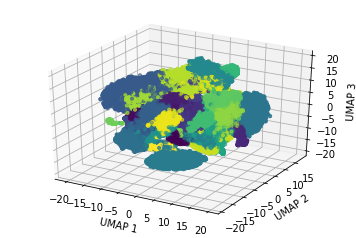

In [27]:
plot(X3d, xx3d, yy3d, zz3d)
#X2d.max()

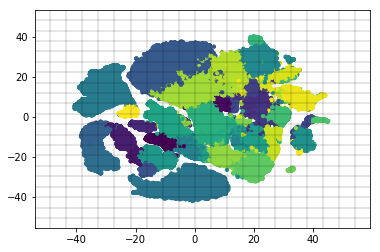

In [11]:
plot(X2d, xx2d, yy2d)
#np.shape(X2d)

#mca_df = pd.read_csv(path, sep="\t")#.sample(n=50000, random_state=1)
#labels = mca_df["TypeInt"].values
#X_1_2 = mca_df[['UMAP1', 'UMAP2']].values
#X_1_3 = mca_df[['UMAP1', 'UMAP3']].values
#X_2_3 = mca_df[['UMAP2', 'UMAP3']].values
#plot(X_1_2, xx2d, yy2d)

In [25]:
result2d, dx2d, dy2d, _ = calc_total_ge(X2d, 10, xx2d, yy2d)
result3d, dx3d, dy3d, dz3d = calc_total_ge(X3d, 10, xx3d, yy3d, zz3d)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


IndexError: getitem out of range

In [ ]:
plt.hist(result2d['entropy'], bins=10)
plt.show()

In [ ]:
min_ge3d = result3d.sort_values('entropy').iloc[0]
print(min_ge3d)
min_ge2d = result2d.sort_values('entropy').iloc[0]
print(min_ge2d)

In [ ]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
for i in xx2d+dx2d*min_ge2d['x_offset']:
    ax.axvline(i, c='k', lw=0.2)
for i in yy2d+dy2d*min_ge2d['y_offset']:
    ax.axhline(i, c='k', lw=0.2)
#for i in zz3d+dz3d*min_ge3d['z_offset']:
#    ax.axvline(i, c='k', lw=0.2)


    
#fig = px.scatter_3d(x=X3d[:, 0], y=X3d[:, 1], z=X3d[:, 2], color=labels)
#fig.update_traces(marker=dict(size=1))
#fig.show()
#ax.scatter(X3d[:, 0], X3d[:, 1], X3d[:, 2], c=labels, marker='o')
ax.scatter(X2d[:, 0], X2d[:, 1], c=labels, s=10)
plt.show()

In [ ]:
X3d, labels = read3d("Gastrulation_Input_3D_TSNE.txt")
results3d = []
X2d, labels = read2d("Gastrulation_Input_2D_TSNE.txt")
results2d = []
for i in (range(1,11)):
    print(i)
    xx3d, yy3d, zz3d = make_grid(X3d, i * 5)
    xx2d, yy2d = make_grid(X2d, i * 5)
    result2d, dx2d, dy2d, _ = calc_total_ge(X2d, 10, xx2d, yy2d)
    result3d, dx3d, dy3d, dz3d = calc_total_ge(X3d, 10, xx3d, yy3d, zz3d)
    results3d.append(result3d)
    results2d.append(result2d)
    #result3d['scaled_entropy'] = result3d['entropy']
    #result2d['scaled_entropy'] = result2d['entropy']
    

In [ ]:
#plt.hist(results2d[0]['entropy'], bins=10)
#results3d.to_csv("results3d_gastrulation.csv", sep="\t")
results2d

In [ ]:
plt.hist(results2d[1]['entropy'], bins=10)

In [ ]:
from matplotlib.pyplot import xticks
min_entropies2d = []
df2d = pd.DataFrame(columns=['entropy', 'x_offset', 'y_offset', 'grid'])
df3d = pd.DataFrame(columns=['entropy', 'x_offset', 'y_offset', 'grid'])
for (i,result) in enumerate(results2d):
    #print(result.sort_values('entropy').iloc[0][0])
    min_entropies2d.append(result.sort_values('entropy').iloc[0][0])
    new_df = result
    new_df['grid'] = i
    df2d = pd.concat([df2d, new_df], axis=0)
    
    
    #df2d['grid'].append(i)
    
min_entropies3d = []
for result in results3d:
    #print(result.sort_values('entropy').iloc[0][0])|
    min_entropies3d.append(result.sort_values('entropy').iloc[0][0])
    new_df = result
    new_df['grid'] = i
    df3d = pd.concat([df2d, new_df], axis=0)
    

    
df3d.to_csv("results3d_gastrulation_tsne.csv", sep="\t")
df2d.to_csv("results2d_gastrulation_tsne.csv", sep="\t")

fig, ax = plt.subplots()
x = np.arange(5, 55, 5).tolist()
ax.plot(x, min_entropies2d, label="2D Total entropy")
ax.plot(x, min_entropies3d, label="3D Total entropy")
xticks(np.arange(5, 55, step=5))
ax.legend()
plt.show()

In [ ]:
min_entropies2d

In [ ]:
np.min(df3d['entropy'])
